In [0]:
import glob
import os
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.image as mpimg
import pandas as pd
import cv2


class FacialKeypointsDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.key_pts_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.key_pts_frame)

    def __getitem__(self, idx):
        image_name = os.path.join(self.root_dir,
                                self.key_pts_frame.iloc[idx, 0])
        
        image = mpimg.imread(image_name)
        
        # if image has an alpha color channel, get rid of it
        if(image.shape[2] == 4):
            image = image[:,:,0:3]
        
        key_pts = self.key_pts_frame.iloc[idx, 1:].values
        key_pts = key_pts.astype('float').reshape(-1, 2)
        sample = {'image': image, 'keypoints': key_pts}

        if self.transform:
            sample = self.transform(sample)

        return sample
    

    
# tranforms

class Normalize(object):
    """Convert a color image to grayscale and normalize the color range to [0,1]."""        

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)

        # convert image to grayscale
        image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # scale color range from [0, 255] to [0, 1]
        image_copy=  image_copy/255.0
            
        
        # scale keypoints to be centered around 0 with a range of [-1, 1]
        # mean = 100, sqrt = 50, so, pts should be (pts - 100)/50
        key_pts_copy = (key_pts_copy - 100)/50.0


        return {'image': image_copy, 'keypoints': key_pts_copy}


class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = cv2.resize(image, (new_w, new_h))
        
        # scale the pts, too
        key_pts = key_pts * [new_w / w, new_h / h]

        return {'image': img, 'keypoints': key_pts}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        key_pts = key_pts - [left, top]

        return {'image': image, 'keypoints': key_pts}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
         
        # if image has no grayscale color channel, add one
        if(len(image.shape) == 2):
            # add that third color dim
            image = image.reshape(image.shape[0], image.shape[1], 1)
            
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(image),
                'keypoints': torch.from_numpy(key_pts)}

In [0]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
# !mkdir data
# !wget -P data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
# !unzip -n data/train-test-data.zip -d data

In [3]:
!ls .

data  sample_data  saved_models


In [0]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

(240, 277, 4)


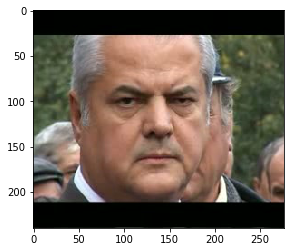

In [6]:
img = mpimg.imread('data/training/Adrian_Nastase_42.jpg')
print(img.shape)
plt.imshow(img)

(270, 312, 4)


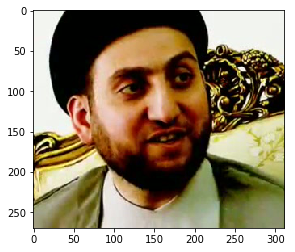

In [7]:
img = mpimg.imread('data/training/Abdel_Aziz_Al-Hakim_00.jpg')
print(img.shape)
plt.imshow(img)

In [0]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250), #250
                                     RandomCrop(224), #224
                                     Normalize(),
                                     ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [9]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


In [0]:
# load training data in batches
batch_size = 128

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

In [0]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)

In [0]:
# load test data in batches
batch_size = 128

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

In [0]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image'].type(torch.FloatTensor).to('cuda')
        key_pts = sample['keypoints'].to('cuda')

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

In [0]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')

In [0]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):
    test_images = test_images.cpu()
    test_outputs = test_outputs.cpu()
    for i in range(batch_size):
        plt.figure(figsize=(40,30))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image
        ##because in pytorch C is first, in numpy its last.

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            gt_pts = gt_pts.cpu()
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()

In [0]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()
    losses=[]
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image'].type(torch.FloatTensor).to('cuda')
            key_pts = data['keypoints'].type(torch.FloatTensor).to('cuda')

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                losses.append(running_loss)
                running_loss = 0.0

    print('Finished Training')
    return losses

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# can use the below import should you choose to initialize the weights of your Net
import torch.nn.init as I

class Net3(nn.Module):

    def __init__(self):
        super(Net3, self).__init__() 
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        
        self.pool=nn.MaxPool2d(2,2)
        
        self.fc=nn.Linear(64*21*21,1024)
        self.bn = nn.BatchNorm1d(1024)
        
        self.fc2=nn.Linear(1024,512)
        self.bn2 = nn.BatchNorm1d(512)
        
        self.dp = nn.Dropout(0.4)

        self.out=nn.Linear(512,136)
        
    def forward(self, x):
        x = F.relu(self.pool(self.conv1(x)))
        x = F.relu(self.pool(self.conv2(x)))
#         print("Aaage: ",x.shape)
        x = x.reshape(x.shape[0],-1)
#         print("Poore: ",x.shape)
#         return 
        x = F.relu(self.fc(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# can use the below import should you choose to initialize the weights of your Net
import torch.nn.init as I

class Net2(nn.Module):

    def __init__(self):
        super(Net2, self).__init__() 
        self.conv1 = nn.Conv2d(1, 32, 4)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 2)
        self.conv4 = nn.Conv2d(128, 256, 1)
        
        self.pool=nn.MaxPool2d(2,2)
        
        self.fc=nn.Linear(43264,1024)
        self.bn = nn.BatchNorm1d(1024)
        
        self.fc2=nn.Linear(1024,512)
        self.bn2 = nn.BatchNorm1d(512)
        
        self.dp1 = nn.Dropout(0.1)
        self.dp2 = nn.Dropout(0.2)
        self.dp3 = nn.Dropout(0.3)
        self.dp4 = nn.Dropout(0.4)
        self.dp5 = nn.Dropout(0.5)
        self.dp6 = nn.Dropout(0.6)

        self.out=nn.Linear(512,136)
        
    def forward(self, x):
        x = self.dp1(self.pool(F.relu(self.conv1(x))))
        x = self.dp2(self.pool(F.relu(self.conv2(x))))
        x = self.dp3(self.pool(F.relu(self.conv3(x))))
        x = self.dp4(self.pool(F.relu(self.conv4(x))))
#         print("Aaage: ",x.shape)
        x = x.reshape(x.shape[0],-1)
        # print("Poore: ",x.shape)
        # return 
        x = self.dp5(F.relu(self.fc(x)))
        x = self.dp6(F.relu(self.fc2(x)))
        x = self.out(x)
        return x

In [0]:
net = Net2().to('cuda')
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(net.parameters())

In [0]:
# model_dir = 'saved_models/'
# model_name = 'keypoints_model_net2_60_epochs.pt'
# net.load_state_dict(torch.load(model_dir+model_name))

torch.Size([128, 1, 224, 224])
torch.Size([128, 68, 2])
torch.Size([128, 68, 2])


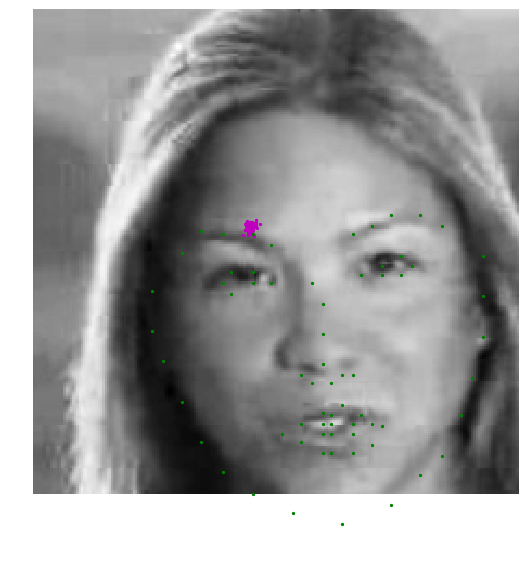

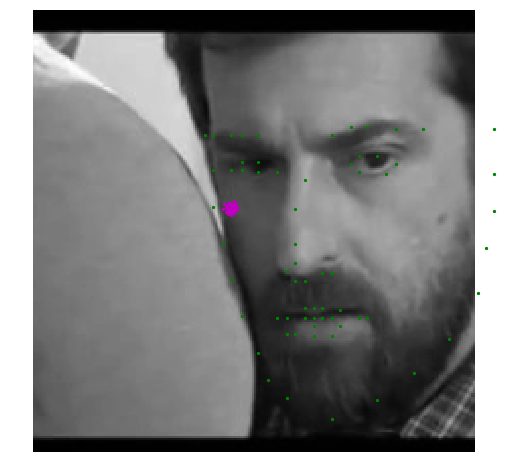

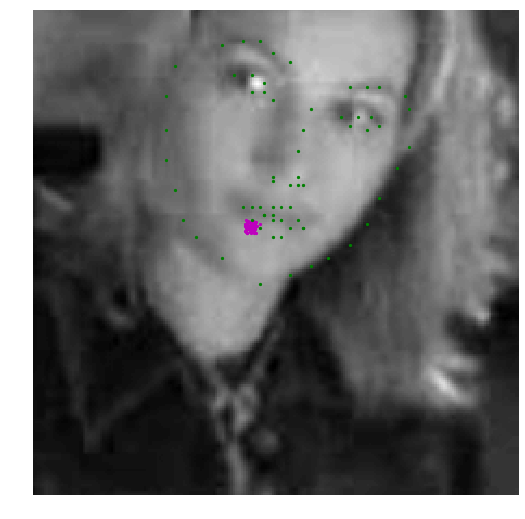

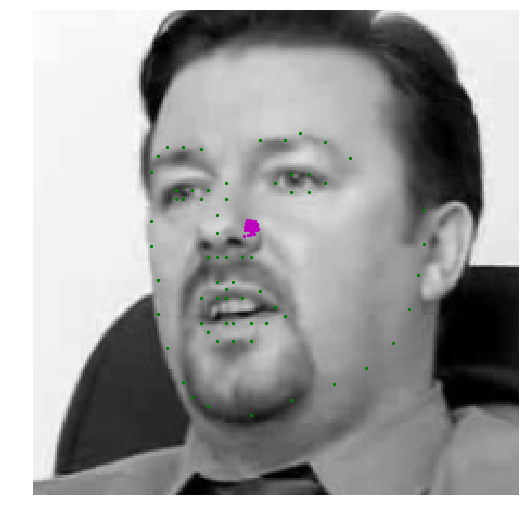

In [21]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())
visualize_output(test_images, test_outputs, gt_pts,4)

In [0]:
umm = []

Epoch: 1, Batch: 10, Avg. Loss: 0.4231972903013229
Epoch: 1, Batch: 20, Avg. Loss: 0.23643983900547028
Epoch: 2, Batch: 10, Avg. Loss: 0.2482352077960968
Epoch: 2, Batch: 20, Avg. Loss: 0.2028454452753067
Epoch: 3, Batch: 10, Avg. Loss: 0.209748338162899
Epoch: 3, Batch: 20, Avg. Loss: 0.20951923578977585
Epoch: 4, Batch: 10, Avg. Loss: 0.1910958468914032
Epoch: 4, Batch: 20, Avg. Loss: 0.19352732449769974
Epoch: 5, Batch: 10, Avg. Loss: 0.19650351107120514
Epoch: 5, Batch: 20, Avg. Loss: 0.2003166526556015
Epoch: 6, Batch: 10, Avg. Loss: 0.18641941994428635
Epoch: 6, Batch: 20, Avg. Loss: 0.18925361931324006
Epoch: 7, Batch: 10, Avg. Loss: 0.16190868765115737
Epoch: 7, Batch: 20, Avg. Loss: 0.1760967418551445
Epoch: 8, Batch: 10, Avg. Loss: 0.17922271192073821
Epoch: 8, Batch: 20, Avg. Loss: 0.156453438103199
Epoch: 9, Batch: 10, Avg. Loss: 0.15609466582536696
Epoch: 9, Batch: 20, Avg. Loss: 0.14884367883205413
Epoch: 10, Batch: 10, Avg. Loss: 0.14790333062410355
Epoch: 10, Batch: 20,

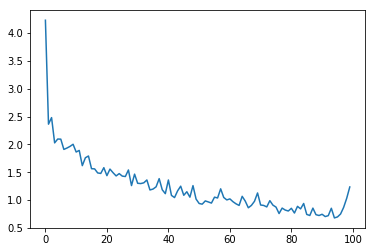

In [23]:
# train your network
n_epochs = 50 # start small, and increase when you've decided on your model structure and hyperparams
losses = train_net(n_epochs)
umm+=losses
plt.plot(list(range(len(umm))),umm)

In [32]:
losses = train_net(10)

Epoch: 1, Batch: 10, Avg. Loss: 0.09412736967206001
Epoch: 1, Batch: 20, Avg. Loss: 0.08627894893288612
Epoch: 2, Batch: 10, Avg. Loss: 0.08832784444093704
Epoch: 2, Batch: 20, Avg. Loss: 0.09077474474906921
Epoch: 3, Batch: 10, Avg. Loss: 0.08284870758652688
Epoch: 3, Batch: 20, Avg. Loss: 0.07341397628188133
Epoch: 4, Batch: 10, Avg. Loss: 0.07132951207458973
Epoch: 4, Batch: 20, Avg. Loss: 0.07754742875695228
Epoch: 5, Batch: 10, Avg. Loss: 0.07996626496315003
Epoch: 5, Batch: 20, Avg. Loss: 0.08494095392525196
Epoch: 6, Batch: 10, Avg. Loss: 0.07585864178836346
Epoch: 6, Batch: 20, Avg. Loss: 0.0780036624521017
Epoch: 7, Batch: 10, Avg. Loss: 0.06760039366781712
Epoch: 7, Batch: 20, Avg. Loss: 0.07771760076284409
Epoch: 8, Batch: 10, Avg. Loss: 0.0674744974821806
Epoch: 8, Batch: 20, Avg. Loss: 0.06117720045149326
Epoch: 9, Batch: 10, Avg. Loss: 0.06269893236458302
Epoch: 9, Batch: 20, Avg. Loss: 0.0668407455086708
Epoch: 10, Batch: 10, Avg. Loss: 0.07055113464593887
Epoch: 10, Bat

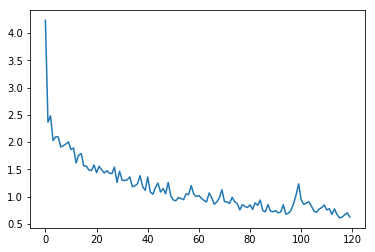

In [33]:
umm+=losses
plt.plot(list(range(len(umm))),umm)

Epoch: 1, Batch: 10, Avg. Loss: 0.0636735711246729
Epoch: 1, Batch: 20, Avg. Loss: 0.0743992269039154
Epoch: 2, Batch: 10, Avg. Loss: 0.07452410943806172
Epoch: 2, Batch: 20, Avg. Loss: 0.06322377473115921
Epoch: 3, Batch: 10, Avg. Loss: 0.06451865509152413
Epoch: 3, Batch: 20, Avg. Loss: 0.0667251244187355
Epoch: 4, Batch: 10, Avg. Loss: 0.060295583307743074
Epoch: 4, Batch: 20, Avg. Loss: 0.06545186191797256
Epoch: 5, Batch: 10, Avg. Loss: 0.05834931321442127
Epoch: 5, Batch: 20, Avg. Loss: 0.06317166686058044
Epoch: 6, Batch: 10, Avg. Loss: 0.06105256341397762
Epoch: 6, Batch: 20, Avg. Loss: 0.06779803261160851
Epoch: 7, Batch: 10, Avg. Loss: 0.0627006821334362
Epoch: 7, Batch: 20, Avg. Loss: 0.06001704968512058
Epoch: 8, Batch: 10, Avg. Loss: 0.05983842089772225
Epoch: 8, Batch: 20, Avg. Loss: 0.06722698546946049
Epoch: 9, Batch: 10, Avg. Loss: 0.07471007965505123
Epoch: 9, Batch: 20, Avg. Loss: 0.0675384521484375
Epoch: 10, Batch: 10, Avg. Loss: 0.0678821250796318
Epoch: 10, Batch

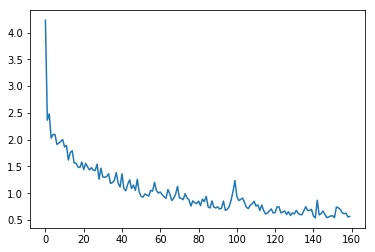

In [37]:
losses = train_net(20)
umm+=losses
plt.plot(list(range(len(umm))),umm)

In [0]:
# !mkdir saved_models

In [0]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_net2_80_epochs.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [34]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([128, 1, 224, 224])
torch.Size([128, 68, 2])
torch.Size([128, 68, 2])


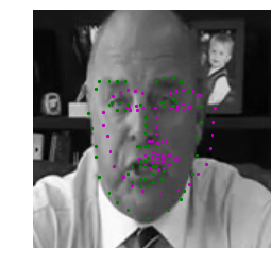

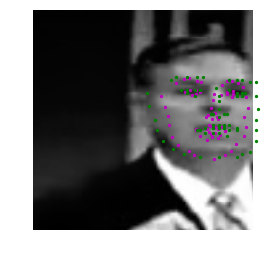

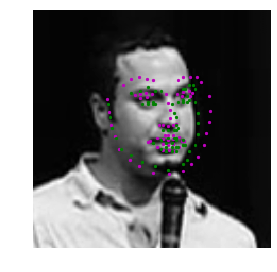

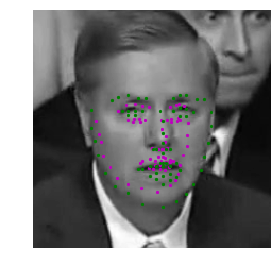

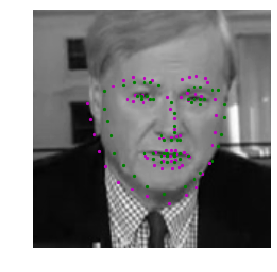

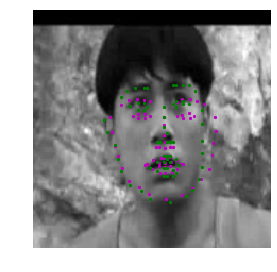

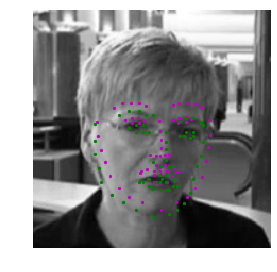

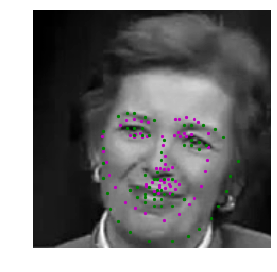

In [35]:
visualize_output(test_images, test_outputs, gt_pts, 8)

Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**:
The optimization I chose was Adam. Adam is widely adopted in many Computer Vision and Natural Language Processing Task. It combines AdaGrad and RMSProp and so contains the best characters of both optimizations. It is able to converge to the minima of the task at hand fast and efficiently. Due to its benchmark performances, I chose Adam optimizer as for my model.

The problem we have at hand is a regression problem. The loss function avaiable for use are MSE, MAE or SmoothL1.
The problem of using L1 loss in neural networks is that its gradient is constant, and so network might have problem learning. On the other hand, MSE behaves nicely and smoothly converges to minima with a fixed learning rate. For this reason I used MSE as the loss function.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: 
In the begining working without GPU proved tough. I tried small network with 2 conv layers and 2/1 linear layer. On training the observation was that the loss wasnt reducing at all. The model was badly underfitting and it thus required a larger network. Moving on to GPU, I created a model woth 3-5 conv layers and 2-3 linear layers, all these models performed moderately but not sufficiently good. Then I moved on to implement the model mentioned in the paper provided. This architecture smoothly reduced losses and also the least loss. So this architecture was finalised. I tried using batch normalization. In this task, normalization slows down the speed of learning and even after 100 epochs the loss remains high at 1.2. So batch norm was removed. Later as I increased epoch number the model started overfitting quickly at 30 epochs, so I added regularization through dropout as per the paper, and the overfitting was reduced slightly.

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: 
While building and testing the model, I started by using only 1-3 epoch. As the model finalized, I trained for upto 80 epochs on gpu. I trained for 50 epochs and plotted the loss graph. The loss reduction was consistent. So I trained for more epochs with 10 or 20 epochs interval and kept plotting the graph to detect overfitting. On the last 20 epochs, the loss graph started to flatline, training was stopped at this point. Further epochs at this point would only result in similar loss values as the graphs slope had reduced significantly. Finally I used a epoch number of 80 to train my model.

As for the batch size, it mainly depends on the amount of data the memory is able to hold. In this case, I tried to increase the batch size as far as possible. Using batch size as power of two helps speed up processing as the number of cores are in the power of two. A batch size of 128 was able to fit in memory well and train the model, so I used batch size 128.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

In [28]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


TypeError: ignored

## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

In [0]:
##TODO: load in and display any image from the transformed test dataset

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image


### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: (does it detect vertical lines or does it blur out noise, etc.) write your answer here

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!